In [13]:
import pickle
import matplotlib.pyplot as plt
import json
import torch_geometric
import torch
import networkx as nx
from torch_geometric.data import Data

In [8]:
# once we have run generate_hol_dataset, get graph data dir with (label, conj, stmt) tuples,  and dictionary mapping keys (expression strings) to graphs
# combine_data and combine_dicts puts it all into global train_data, val_data, test_data and global_expr_dict
with open("graph_data/train/holstep000", "rb") as f:
    test = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'graph_data/train/holstep000'

In [3]:
# takes expression key and maps to node_features (as one_hot indices), and edge_index
with open("graph_data/global_expr_dict.pk", "rb") as f:
    graph_dict = pickle.load(f)

In [4]:
one_hot_dict = torch.load("dicts/hol_train_dict")



In [19]:
#generate reverse dict mapping from number to token

reverse_dict = {v : k for k,v in one_hot_dict.items()}

In [5]:
token_keys = list(one_hot_dict.keys())


In [44]:
# one_hot_dict[token_keys[3]]


In [6]:
expr_keys = list(graph_dict.keys())

In [43]:
# graph_dict[expr_keys[0]]

In [7]:
test_expr = test[0][2]

In [9]:
one_hot, edge_index = graph_dict[test_expr]

In [14]:
x = torch.nn.functional.one_hot(torch.LongTensor(one_hot), num_classes=1909)  # .float()
edge_index = torch.LongTensor(edge_index)


test_graph = Data(x, edge_index)

In [103]:

def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"

    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL: 0, CURRENT: 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels = make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1 / levels[currentLevel][TOTAL]
        left = dx / 2
        pos[node] = ((left + dx * levels[currentLevel][CURRENT]) * width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc - vert_gap)
        return pos

    if levels is None:
        levels = make_levels({})
    else:
        levels = {l: {TOTAL: levels[l], CURRENT: 0} for l in levels}
    vert_gap = height / (max([l for l in levels]) + 1)
    return make_pos({})



In [114]:
def draw_graph(data, node_to_token_dict):
    G = nx.DiGraph()


    from_idx = data.edge_index[0]
    to_idx = data.edge_index[1]

    # find source node
    all_nodes = torch.arange(data.num_nodes)
    root_node = [x for x in all_nodes if x not in to_idx]


    node_inds = [x[1].item() for x in data.x.nonzero()]
    for i,ind in enumerate(node_inds):
        token = node_to_token_dict[ind]
        G.add_node(i, token=token)

    edge_index = data.edge_index.t().tolist()
    for edge in edge_index:
        G.add_edge(edge[0], edge[1])

    pos = hierarchy_pos(G,root_node[0].item())
    # pos = nx.spring_layout(G)

    node_labels = nx.get_node_attributes(G, 'token')

    fig = plt.figure(figsize=(10,10))
    nx.draw(G, pos, with_labels=True, labels=node_labels)
    plt.show()


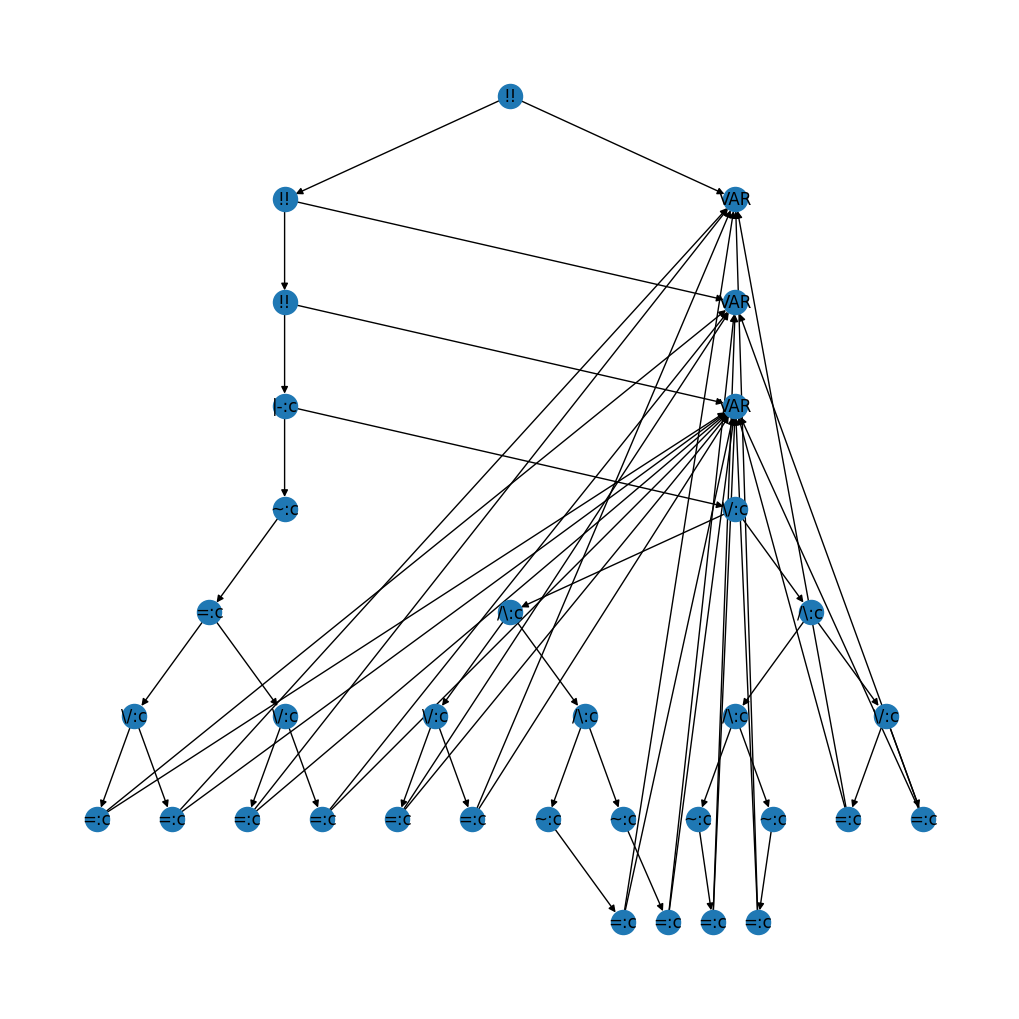

In [115]:
draw_graph(test_graph, reverse_dict)

In [116]:

test_expr



'(~ (((x = A) \\/ (x = B)) = ((x = B) \\/ (x = A)))) |- ((((x = A) \\/ (x = B)) /\\ ((~ (x = B)) /\\ (~ (x = A)))) \\/ (((~ (x = A)) /\\ (~ (x = B))) /\\ ((x = B) \\/ (x = A))))\n'